In [1]:
import pandas as pd
from datetime import datetime
import mplfinance as mpf
import numpy as np

pd.options.mode.chained_assignment = None

## Financial Series Treatment

### My functions

In [3]:
def resamplear_velas(data, period):
    """
    Calculates candlesticks with OHLC and volume from tick-by-tick data.

    Args:
        data (dataframe): tick by tick data, with columns 'price' and 'volume'.
        period (str): period for candlestick calculation.

    Return:
        df (dataframe): resampled data with OHLC and volume.
    """
    df = data.resample(period).agg({"price": "ohlc", "volume": "sum"})
    df.columns = df.columns.droplevel()
    df.dropna(inplace=True)
    df = df.loc[df.volume > 0, :]
    return df

In [4]:
def tick_bars(data, size):
    """
    Calculates tick bars, with OHLC and volume.
    Requires Pandas version 1.5

    Args:
        data (dataframe): data tick by tick.
        size (int): number of trades entering each candle.

    Returns:
        (dataframe): tick candles.
    """
    datacopy = data.copy()
    datacopy.reset_index(inplace=True)
    datacopy["open"] = datacopy.price.rolling(size, step=size).apply(
        lambda rows: rows[0], raw=True
    )
    datacopy["high"] = datacopy.price.rolling(size, step=size).max()
    datacopy["low"] = datacopy.price.rolling(size, step=size).min()
    datacopy["close"] = datacopy.price.rolling(size, step=size).apply(
        lambda rows: rows[-1], raw=True
    )
    datacopy["volume"] = datacopy.volume.rolling(size, step=size).sum()

    datacopy.dropna(inplace=True)
    datacopy.drop(["price"], axis=1, inplace=True)
    return datacopy.set_index("datetime")

In [5]:
def dollar_bars(data, size):
    """
Calculate dollar bars, with OHLC.

    Args:
        data (dataframe): data tick by tick.
        size (int):
            Number of traded dollars needed to calculate each candle.
            If a single tick exceeds n times the size, with n>=2, n candles are calculated.
    Returns:
        (dataframe): candles with OHLC by volume traded in dollars.
    """
    lista = list()
    dollars = 0
    open_index = 0
    dollars_serie = data.price * data.volume
    for i in range(data.shape[0]):
        dollars += dollars_serie[i]
        while dollars > size:
            dicc_temp = {
                "datetime": data.index[i],
                "open": data.price[open_index],
                "high": np.max(data.price[open_index : i + 1]),
                "low": np.min(data.price[open_index : i + 1]),
                "close": data.price[i],
            }
            lista.append(dicc_temp)

            open_index = i  # parto ultima negociacion en dos velas,
            # open siguiente es igual al close.
            dollars = dollars - size

        if dollars == size:
            dicc_temp = {
                "datetime": data.index[i],
                "open": data.price[open_index],
                "high": np.max(data.price[open_index : i + 1]),
                "low": np.min(data.price[open_index : i + 1]),
                "close": data.price[i],
            }

            open_index = i + 1  # no parto ultima negociacion,
            # entonces open siguiente con el tick siguiente
            dollars = dollars - size

            lista.append(dicc_temp)

    return pd.DataFrame(lista).set_index("datetime")

I load the data. I will work with only a part of it (first two million rows).

In [6]:
data = pd.read_csv(
    "IVE_tickbidask.txt",
    header=None,
    parse_dates=True,
    usecols=[0, 1, 2, 5],
    nrows=2000000,
)
#Trabajo la fecha
data.columns = ["date", "time", "price", "volume"]
data["datetime"] = pd.to_datetime(
    data["date"] + " " + data["time"], format="%m/%d/%Y %H:%M:%S"
)
data.set_index("datetime", inplace=True)
data.drop(["date", "time"], axis=1, inplace=True)

#Hay algunos outliers/errores cerca de 1, los elimino.
data.drop(data.loc[data.price < 5].index, axis=0, inplace=True)
data.head()

,price,volume
datetime,,
2009-09-28 09:30:00,50.79,100
2009-09-28 09:30:00,50.71,638
2009-09-28 09:31:32,50.75,100
2009-09-28 09:31:32,50.75,100
2009-09-28 09:31:33,50.75,100


I calculate hourly, daily, monthly and yearly candles.

In [8]:
%%time
data_1H = resamplear_velas(data, "1H")
data_1D = resamplear_velas(data, "1D")
data_1M = resamplear_velas(data, "1M")
data_1Y = resamplear_velas(data, "1Y")

Wall time: 179 ms


In [9]:
data_1H.head()

,open,high,low,close,volume
datetime,,,,,
2009-09-28 09:00:00,50.7900,51.15,50.7100,51.1200,89360
2009-09-28 10:00:00,51.1500,51.38,51.1500,51.2900,167303
2009-09-28 11:00:00,51.2891,51.44,51.2891,51.4073,137408
2009-09-28 12:00:00,51.4100,51.51,51.4100,51.4180,40761
2009-09-28 13:00:00,51.4200,51.60,51.4104,51.4800,65937


In [10]:
data_1D.head()

,open,high,low,close,volume
datetime,,,,,
2009-09-28,50.79,51.60,50.71,51.5400,810911
2009-09-29,51.78,51.96,51.37,51.4900,467547
2009-09-30,51.66,51.69,50.78,51.2900,454623
2009-10-01,51.16,51.16,49.78,50.3166,861723
2009-10-02,49.30,49.81,49.19,49.5100,874909


In [11]:
data_1M.head()

,open,high,low,close,volume
datetime,,,,,
2009-09-30,50.79,51.9600,50.71,51.2900,1733081
2009-10-31,51.16,53.0822,49.18,49.3602,11602304
2009-11-30,49.63,53.2100,48.93,52.4400,9669746
2009-12-31,52.87,53.9600,52.27,53.0100,9522785
2010-01-31,53.55,55.1790,51.84,51.8900,8547593


In [12]:
data_1Y.head()

,open,high,low,close,volume
datetime,,,,,
2009-12-31,50.79,53.96,48.93,53.01,32527916
2010-12-31,53.55,59.87,29.30,59.59,138871936
2011-12-31,60.02,65.26,48.73,57.83,136375242
2012-12-31,57.83,68.00,57.66,66.39,109454874
2013-12-31,67.18,84.54,67.18,84.25,138209215


Hago un grafico de velas para cada apartado anterior.

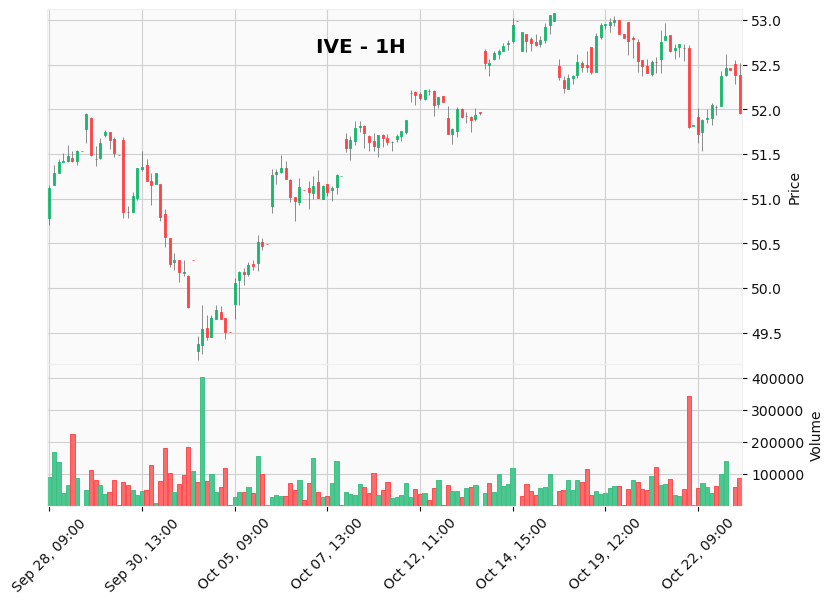

In [13]:
mpf.plot(
    data_1H.iloc[:150, :],
    type="candle",
    volume=True,
    title="IVE - 1H",
    tight_layout=True,
    style="yahoo",
)

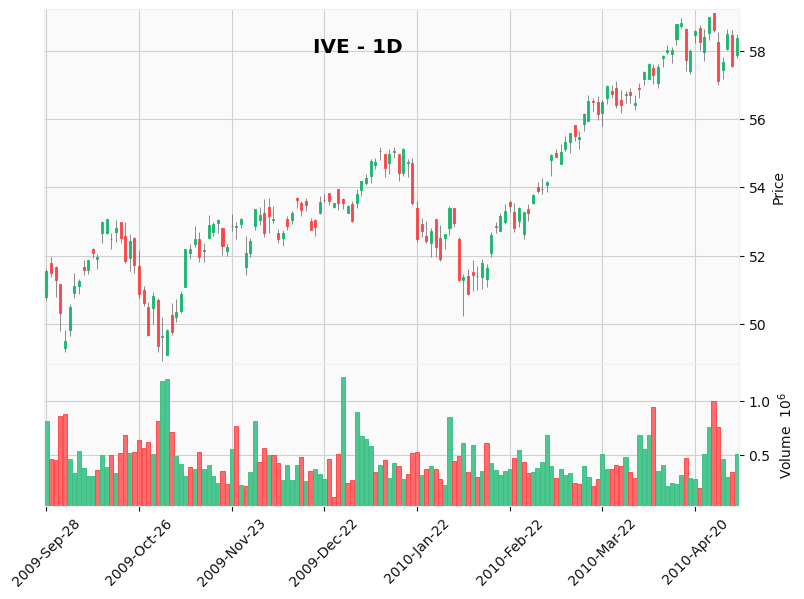

In [14]:
mpf.plot(
    data_1D.iloc[:150, :],
    type="candle",
    volume=True,
    title="IVE - 1D",
    tight_layout=True,
    style="yahoo",
)

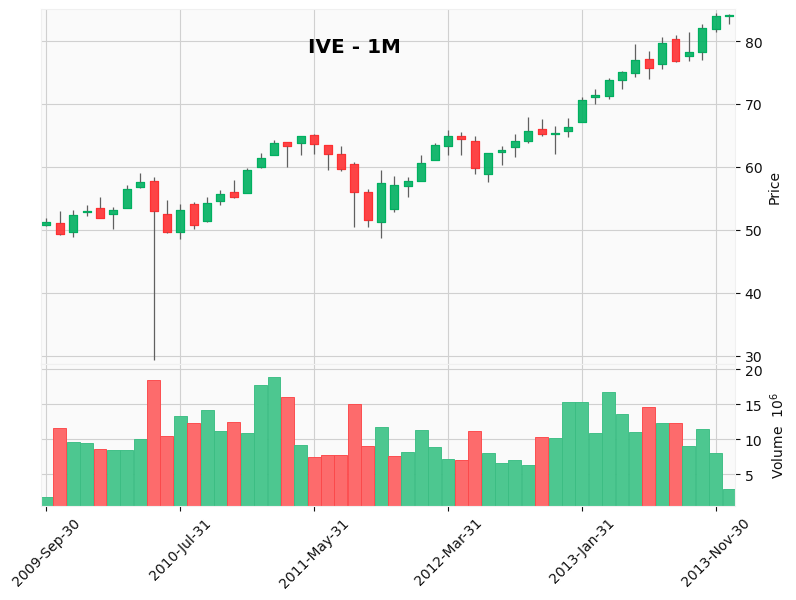

In [15]:
mpf.plot(
    data_1M,
    type="candle",
    volume=True,
    title="IVE - 1M",
    tight_layout=True,
    style="yahoo",
)

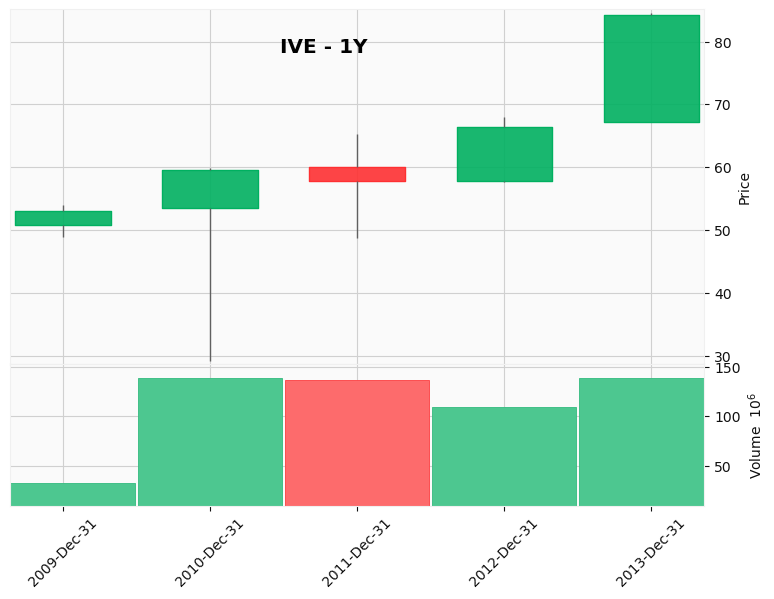

In [16]:
mpf.plot(
    data_1Y,
    type="candle",
    volume=True,
    title="IVE - 1Y",
    tight_layout=True,
    style="yahoo",
)

**Tick bars**. I test the function with 10000 negotiations.

In [17]:
%%time
data_tickbars = tick_bars(data, 10000)
data_tickbars

Wall time: 585 ms


,volume,open,high,low,close
datetime,,,,,
2009-10-01 15:08:32,2324548.0,50.7100,51.9600,50.05,50.0500
2009-10-08 09:38:00,2512900.0,50.0500,51.7400,49.19,51.7000
2009-10-15 15:14:41,2156161.0,51.7000,53.0200,51.43,52.9448
2009-10-22 09:29:16,2136241.0,52.9548,53.0822,51.79,51.9200
2009-10-27 15:07:11,2178442.0,51.9200,52.6200,50.54,50.8000
...,...,...,...,...,...
2013-10-22 14:54:50,2567696.0,79.6647,82.0700,79.19,81.9100
2013-11-01 10:30:59,2508090.0,81.9100,82.7100,81.14,81.8400
2013-11-12 12:59:45,2759634.0,81.8800,82.8802,81.53,82.4200


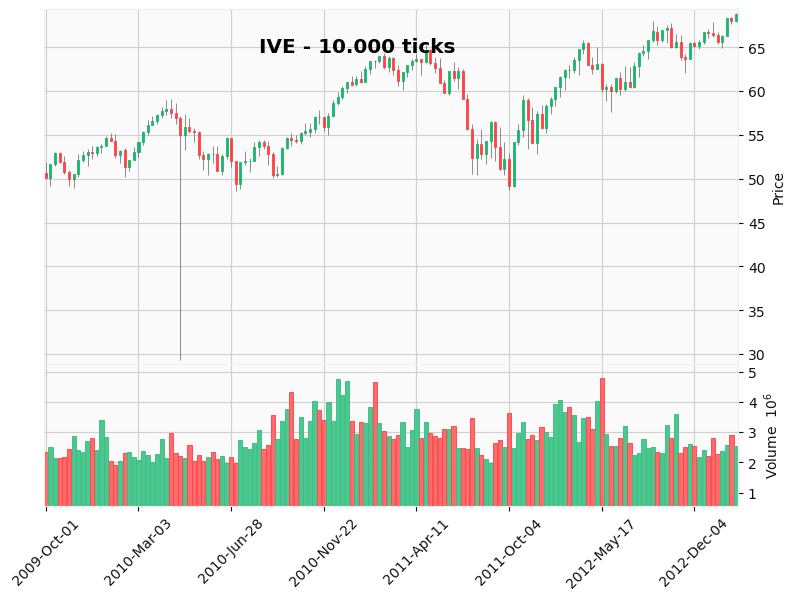

In [18]:
mpf.plot(
    data_tickbars.iloc[:150, :],
    type="candle",
    volume=True,
    title="IVE - 10.000 ticks",
    tight_layout=True,
    style="yahoo",
)


**Dollar bars.**
I test the function with $100,000.

In [19]:
%%time
data_dollarbars = dollar_bars(data.iloc[:20000,:], size=100000)
data_dollarbars

Wall time: 751 ms


,open,high,low,close
datetime,,,,
2009-09-28 09:31:50,50.7900,50.7900,50.7100,50.7500
2009-09-28 09:33:02,50.7500,50.8226,50.7500,50.8100
2009-09-28 09:33:54,50.8100,50.8200,50.8100,50.8200
2009-09-28 09:37:33,50.8200,50.8500,50.8000,50.8299
2009-09-28 09:41:33,50.8299,50.8299,50.7833,50.8000
...,...,...,...,...
2009-10-08 09:32:11,51.6900,51.6900,51.6000,51.6800
2009-10-08 09:33:29,51.6800,51.7000,51.6300,51.6300
2009-10-08 09:35:51,51.6300,51.6300,51.5900,51.6000


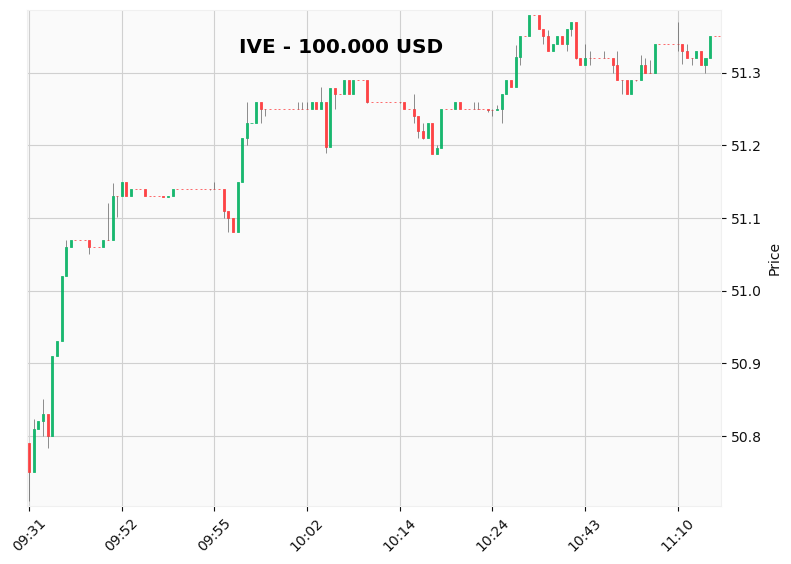

In [22]:
mpf.plot(
    data_dollarbars.iloc[:150, :],
    type="candle",
    volume=False,
    title="IVE - 100.000 USD",
    tight_layout=True,
    style="yahoo",
)

Calculate and compare returns for 1D, 10,000 trades and $1,000,000

In [23]:
%%time
data_dollarbars = dollar_bars(data.iloc[:50000], size=1000000)

Wall time: 319 ms


<AxesSubplot:title={'center':'Densidad Kernel de los retornos logarítmicos'}, ylabel='Density'>

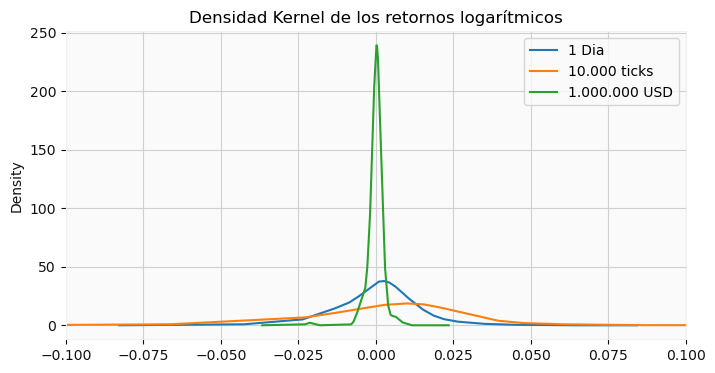

In [24]:
logret_1D = np.array(np.log(data_1D.close / data_1D.close.shift()))
logret_10K_trades = np.array(np.log(data_tickbars.close / data_tickbars.close.shift()))
logret_1M_usd = np.array(np.log(data_dollarbars.close / data_dollarbars.close.shift()))

log_returns = pd.DataFrame(
    {
        "1 Dia": logret_1D[0:199],
        "10.000 ticks": logret_10K_trades,
        "1.000.000 USD": logret_1M_usd[:199],
    }
)
log_returns.dropna(inplace=True)
log_returns.plot.kde(
    figsize=(8, 4),
    xlim=(-0.1, 0.1),
    title="Densidad Kernel de los retornos logarítmicos",
)

The clearest difference that can be observed is the kurtosis for 1 million USD candlesticks returns distribution, being much higher than the other two. 
In addition, the mean of this one is also better centered at zero.  
Then, although they all have negative skewness, the strongest skewness is also for the 1 million USD distribution. 

## Triple-Barrier Method (Lopez de Prado)

### Mis funciones

In [25]:
def triple_barrier_m(data, length, height):
    """
    Generate labels according to the 'Triple Barrier Method' and 
    Calculates a metric balance of the labels,
    between 0 and 1, with 1 being the perfect balance.
    
    Args:
        data (dataframe):
        length (int): candles for vertical barrier.
        height (float): percentage for horizontal barriers
    Returns:
        datacopy (dataframe):
            Copy of dataframe input, adding label column.
        metrica_balance (float): between 0 and 1.
    """
    datacopy = data.copy()
    output = list()
    # I lose the last "length" data, so that it does not
    # calculate them with a decreasing candle window.
    for i in range(len(data)-length):

        df = data_dollarbars.close[i:i+length]
        upper_band = df[0]*(1+height/100) 
        lower_band = df[0]*(1-height/100)

        etiquetas = np.where(df >= upper_band, 1,
                             (np.where(df <= lower_band, -1, 0)))

        if any(etiquetas != 0):
            # If there are labels other than 0,
            # I want the first one to happen.
            output.append(etiquetas[etiquetas != 0][0])
        else:
            output.append(0)
    datacopy.drop(datacopy.index[-length:],axis=0, inplace=True)
    datacopy["labels"] = np.array(output) 
    
    #Metric label balance calculation
    if len(pd.value_counts(datacopy.labels)) == 3:
        a = pd.value_counts(datacopy.labels).iloc[0]/len(datacopy)
        b = pd.value_counts(datacopy.labels).iloc[1]/len(datacopy)  
        c = pd.value_counts(datacopy.labels).iloc[-1]/len(datacopy)
        metrica_balance = (a*b*c)/(1/3)**3
    else:
        metrica_balance = 0
    
    return datacopy, metrica_balance

In [26]:
def estudio_labels(data, porcentajes, velas):
    """
    Calculates for a given grid of percentages and candles,
    the "balance metric", between 0 and 1, with 1 being the perfect balance between the
    between the labels of the "Triple Barrier Method".
    
    Args:
        data (dataframe)
        porcentajes (array): different amplitudes of horizontal barriers
        velas (array): different amplitudes of vertical barriers
        
    Returns:
        df_estudio_labels (dataframe)
        
    """
    df_estudio_labels = pd.DataFrame(columns=porcentajes,
                                              index=velas)
    df_estudio_labels.index.rename("Velas", inplace=True)
    df_estudio_labels.columns.rename("Porcentajes", inplace=True)
    for i, length in enumerate(velas):
        for j, height in enumerate(porcentajes):
            
            *_, metrica_balance = triple_barrier_m(data, length, height)
            
            df_estudio_labels.iloc[i, j] = metrica_balance
    return df_estudio_labels

I calculate for each sample a label, "triple barrier method". \
I test my function for 10 candles and 0.5%.

In [27]:
%%time
dollarbars_labels, *_ = triple_barrier_m(data=data_dollarbars,
                                     length=10,
                                     height=0.5)
dollarbars_labels.head()

Wall time: 225 ms


,open,high,low,close,labels
datetime,,,,,
2009-09-28 09:46:34,50.790,51.070,50.710,51.070,0
2009-09-28 09:52:47,51.070,51.148,51.050,51.130,0
2009-09-28 09:54:36,51.130,51.150,51.129,51.129,0
2009-09-28 09:54:43,51.129,51.140,51.129,51.140,0
2009-09-28 10:01:06,51.140,51.260,51.080,51.259,0


I want to look for a way to get the number of labels
as balanced as possible

In [28]:
%%time
porcentajes = np.array(np.arange(0.1, 1.1, 0.05))
velas = np.array(range(5, 55, 5))

df_resultados_optimizacion = estudio_labels(data=data_dollarbars,
                                            porcentajes=porcentajes, 
                                            velas=velas)
df_resultados_optimizacion

Wall time: 33 s


Porcentajes,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00,1.05
Velas,,,,,,,,,,,,,,,,,,,,
5,0.501113,0.772905,0.996844,0.926877,0.774083,0.638497,0.5308,0.419739,0.311097,0.191955,0.152699,0.096502,0.069561,0.047907,0.036184,0.029889,0.02198,0.013915,0.009361,0.006285
10,0.046337,0.167026,0.425365,0.674361,0.838499,0.92926,0.990478,0.993823,0.935871,0.797287,0.704129,0.595184,0.466702,0.38352,0.34499,0.286481,0.241573,0.185548,0.139076,0.105835
15,0,0.035122,0.103469,0.199984,0.355759,0.469605,0.689621,0.807285,0.930321,0.998208,0.988017,0.947541,0.901343,0.820854,0.757911,0.6877,0.62012,0.514312,0.425642,0.376498
20,0,0.011904,0.035539,0.070092,0.158207,0.232384,0.376787,0.505715,0.603228,0.80113,0.892836,0.959382,0.98367,0.999313,0.991208,0.963688,0.925517,0.850942,0.722165,0.648823
25,0,0,0,0,0.023669,0.081853,0.159815,0.224426,0.285904,0.508699,0.633473,0.743433,0.813709,0.894742,0.925716,0.969561,0.9961,0.978919,0.906692,0.84775
30,0,0,0,0,0,0.035923,0.059387,0.082921,0.128779,0.277117,0.409514,0.534643,0.587507,0.714432,0.749254,0.832829,0.921817,0.980282,0.9898,0.963336
35,0,0,0,0,0,0,0.012136,0.024285,0.024333,0.106353,0.173148,0.277713,0.355889,0.507378,0.593209,0.695312,0.8097,0.926148,0.979024,0.990427
40,0,0,0,0,0,0,0,0,0,0.036412,0.060174,0.10647,0.151449,0.2905,0.369183,0.487164,0.63356,0.784505,0.88462,0.952982
45,0,0,0,0,0,0,0,0,0,0.012322,0.012322,0.036611,0.060616,0.187352,0.2524,0.335185,0.4568,0.62367,0.751283,0.836622


In [40]:
optimo = df_resultados_optimizacion[
    df_resultados_optimizacion == max(df_resultados_optimizacion.max())
]
optimo.dropna(axis=1, how="all", inplace=True)
optimo.dropna(axis=0, how="all", inplace=True)

f"La mejor combinacion del grid es con length={optimo.index[0]} y height={round(optimo.columns[0],2)}"

'La mejor combinacion del grid es con length=20 y height=0.75'

I check

In [41]:
dollarbars_labels, *_ = triple_barrier_m(data=data_dollarbars, length=20, height=0.75)
dollarbars_labels.labels.value_counts()

 0    193
 1    185
-1    184
Name: labels, dtype: int64